# Sistema de Recomendação

Este notebook apresenta algumas implementações de sistema de recomendação utilizando
o dataset Movielens.
Este notebook utiliza dois modelos:
 1. Modelo de Sistema de Recomendação utilizando atributos latentes e produto interno
 2. Modelo utilizando atributos latentes concatenados e uma rede neural
 
Para o modelo 2:
- Calcula a predição para todos os filmes e usuários que não fizeram suas avaliações
- Visualiza a matriz de avaliações por usuários x filmes com todas as predições
- Análise do significado dos embeddings

Obs: Este notebook foi inspirado em exemplo divulgado pelo curso online disponível em [fast.ai](http://fast.ai)

## Importação da bibliotecas

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as np
import os, sys
import pandas as pd

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

In [3]:
np.set_printoptions(formatter={'float': '{: 0.1f}'.format})

import lib.pytorch_trainer as ptt

use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: True


## Movielens dataset

- [Movielens - Readme](http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html)
- Movielens - Small data set - 100.000 avaliações:[ml-latest-small.zip](http://files.grouplens.org/datasets/movielens/ml-latest-small.zip)

F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4, Article 19 (December 2015).


### Leitura dos Dados - Movielens dataset

Caso a célula a seguir falhar, é necessário executar o notebook:
- [Movielens Dataset](MovieLens_dataset_pytorch.ipynb) que é responsável por ler o dataset original e
prepará-lo para este notebook

Este dataset consiste de:
- 100.004 avaliações de filmes (amostras), feitas por
- 671 usuários, sobre
- 9066 filmes

As amostras estão no array `ratings` organizados da seguinte forma:
- cada linha é uma amostra
- coluna 0 é o iD do usuário
- coluna 1 é o iD do filme
- coluna 2 é a avaliação do usuários entre 0.0 e 5.0

In [4]:
data = np.load('../data/movielens_norm.npz')
ratings     = data['ratings']
movie_names = data['movie_names']
n_samples   = ratings.shape[0]
print('n_samples:',n_samples)
print('ratings:\n', ratings[:5])

n_samples: 100004
ratings:
 [[ 0.0  30.0  2.5]
 [ 0.0  833.0  3.0]
 [ 0.0  859.0  3.0]
 [ 0.0  906.0  2.0]
 [ 0.0  931.0  4.0]]


In [5]:
for i in (ratings[:5,1]).astype(np.int):
    print(movie_names[i])

Dangerous Minds (1995)
Dumbo (1941)
Sleepers (1996)
Escape from New York (1981)
Cinema Paradiso (Nuovo cinema Paradiso) (1989)


In [6]:
h_userId  = np.bincount(ratings[:,0].astype(np.int))
n_users   = h_userId.size
h_movieId = np.bincount(ratings[:,1].astype(np.int))
n_movies  = h_movieId.size
print('n_users:',n_users)
print('n_movies:',n_movies)

n_users: 671
n_movies: 9066


## Divisão dos dados em treinamento e validação

In [7]:
np.random.seed = 42

Faz a divisão com 80% das amostras para treinamento e 20% para validação:

In [8]:
msk = np.random.rand(n_samples) < 0.8
train = ratings[msk]
valid = ratings[~msk]
print('train:',train.shape[0],' amostras:\n',train[:5])
print('valid:',valid.shape[0],' amostras:\n',valid[:5])

train: 79988  amostras:
 [[ 0.0  30.0  2.5]
 [ 0.0  833.0  3.0]
 [ 0.0  931.0  4.0]
 [ 0.0  1017.0  2.0]
 [ 0.0  1041.0  2.0]]
valid: 20016  amostras:
 [[ 0.0  859.0  3.0]
 [ 0.0  906.0  2.0]
 [ 0.0  1087.0  2.0]
 [ 0.0  1111.0  2.5]
 [ 1.0  100.0  4.0]]


`userId` e `movieId` precisam ser inteiros pois são entradas do *Embedding*:

In [9]:
train_userId  = torch.LongTensor(train[:,0].astype(np.int))
train_movieId = torch.LongTensor(train[:,1].astype(np.int))
train_ratings = torch.FloatTensor(train[:,2:3]) # importante que fique bidimensional
valid_userId  = torch.LongTensor(valid[:,0].astype(np.int))
valid_movieId = torch.LongTensor(valid[:,1].astype(np.int))
valid_ratings = torch.FloatTensor(valid[:,2:3]) # importante que fique bidimensional

## Definição da classe MLDataset

In [10]:
from torch.utils.data import Dataset
class MLDataset(Dataset):
    def __init__(self, data_user, data_movie, target):
        assert data_user.size(0)  == target.size(0) and \
               data_movie.size(0) == target.size(0)
        
        self.data   = torch.transpose(torch.stack( (data_user, data_movie) ),0,1)
        self.target = target

    def __len__(self):
        return self.target.size(0)

    def __getitem__(self, i):
        return (self.data[i], self.target[i])

### Criação dos objetos datasets e dataloaders

In [11]:
datasets = {
    'train': MLDataset(train_userId, train_movieId, train_ratings),
    'val'  : MLDataset(valid_userId, valid_movieId, valid_ratings)
    }

dataloaders = {
    'train': torch.utils.data.DataLoader(datasets['train'], batch_size=64, shuffle=True),
    'val'  : torch.utils.data.DataLoader(datasets['val'],   batch_size=64, shuffle=True)
    }

dataset_sizes = {
    'train': len(datasets['train']),
    'val'  : len(datasets['val'])
    }

print(dataset_sizes)

{'train': 79988, 'val': 20016}


### Testando os datasets

In [12]:
x, y = datasets['train'][3:5]
print(x)
print(y)


    0  1017
    0  1041
[torch.LongTensor of size 2x2]


 2
 2
[torch.FloatTensor of size 2x1]



### Testando os dataloaders

In [13]:
batch_size = 64
print( len(dataloaders['val']) * batch_size ) # verificando mini-batches
for k,data in enumerate(dataloaders['val']):
    print(k, len(data[0]), len(data[1]))
    if k > 1: break

20032
0 64 64
1 64 64
2 64 64


## Primeira solução - usando produto interno: Dot

<img src='../figures/Recomendacao_dot.png', width=600ptx></img>

O primeiro modelo é o produto interno entre os atributos latentes dos usuários e dos filmes.
Este produto interno é implementado pelo produto elemento por elemento das matrizes
de atributos dos usuários e dos filmes e posteriormente somado, resultado um valor escalar por amostra:

In [14]:
class DotNet(nn.Module):
    def __init__(self, n_users, n_movies, n_attributes):
        """
        No construtor, criamos as duas embeddings, uma para os usuários e 
        outra para os filmes.
        """
        super(DotNet, self).__init__()
        self.user_emb  = nn.Embedding(n_users, n_attributes)
        nn.init.xavier_uniform(self.user_emb.weight)
        self.movie_emb = nn.Embedding(n_movies, n_attributes)
        nn.init.xavier_uniform(self.movie_emb.weight)

    def forward(self, x):
        """
        x: (user_id, movie_id)
        """
        user_id  = x[:,0]
        movie_id = x[:,1]
        user_attr  = self.user_emb(user_id)
        movie_attr = self.movie_emb(movie_id)
        y_pred = (user_attr * movie_attr).sum(1)
        return y_pred


### Instanciando a rede

Utilizando o tamanho do embedding como 50. São 50 atributos, tanto para cada filme como para cada usuário.

In [15]:
n_factors = 50
model_dot = DotNet(n_users, n_movies, n_factors)
if use_gpu:
    model_dot = model_dot.cuda()
model_dot

DotNet(
  (user_emb): Embedding(671, 50)
  (movie_emb): Embedding(9066, 50)
)

### Treinando a rede

In [16]:
optimizer = torch.optim.Adam(model_dot.parameters())
savebest  = ptt.ModelCheckpoint('../../models/recomendacao_dot', reset=True, verbose=1)

trainer = ptt.DeepNetTrainer(
    model         = model_dot, 
    criterion     = nn.MSELoss(), 
    optimizer     = torch.optim.Adam(model_dot.parameters()), 
    callbacks     = [savebest, ptt.PrintCallback()]
                     )

In [17]:
flag_train = False

In [18]:
if flag_train:
    trainer.fit_loader(n_epochs=12, train_data=dataloaders['train'], valid_data=dataloaders['val'])
else:
    trainer.load_state(file_basename='/data/models/recomendacao_dot')

#### Treinamento em GPU 1080:

    Start training for 12 epochs
      1:   1.1s   T: 10.66381   V: 4.25263 best
      2:   1.1s   T: 2.39366   V: 1.84656 best
      3:   1.1s   T: 1.21727   V: 1.44605 best
      4:   1.1s   T: 0.89799   V: 1.31439 best
      5:   1.1s   T: 0.74514   V: 1.27368 best
      6:   1.1s   T: 0.64347   V: 1.25494 best
      7:   1.1s   T: 0.56907   V: 1.24817 best
      8:   1.1s   T: 0.50788   V: 1.25265 
      9:   1.1s   T: 0.45414   V: 1.25994 
     10:   1.1s   T: 0.40561   V: 1.27066 
     11:   1.1s   T: 0.35996   V: 1.27665 
     12:   1.1s   T: 0.31718   V: 1.28682 
    Best model was saved at epoch 7 with loss 1.24817: ../../models/recomendacao_dot
    Stop training at epoch: 12/12

### Avaliando a rede

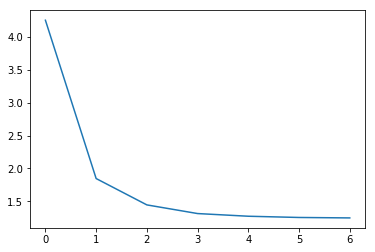

In [19]:
plt.plot(trainer.metrics['valid']['losses'])
plt.show()

In [20]:
print('Best loss:', trainer.metrics['valid']['losses'][-1])

Best loss: 1.2481659148562338


Os bons modelos [best benchmarks](http://www.librec.net/example.html) são próximos de 0.9, há necessidade de melhorias.

### Predição de usuário e filme

Para calcular qualquer predição de qualquer usuário e qualquer filme, usa-se o `predict` do modelo treinado:

In [21]:
# user_id: 3 e movie_id: 6
trainer.predict(torch.LongTensor([[3, 6]]))


 3.7015
[torch.cuda.FloatTensor of size 1 (GPU 0)]

##  Solução com Rede Neural

Uma solução usando rede neural é concatenar a saída dos embeddings e em seguida colocar uma camada densa
antes da última camada de um neurônio. No exemplo a seguir foi utilizado uma camada de 70 neurônios.

<img src='../figures/Recomendacao_NN.png', width=600ptx></img>

In [22]:
class RecommendNet(nn.Module):
    def __init__(self, n_users, n_movies, n_attributes):
        """
        No construtor, criamos as duas embeddings, uma para os usuários e 
        outra para os filmes e duas densas.
        """
        super(RecommendNet, self).__init__()
        self.user_emb  = nn.Embedding(n_users, n_attributes)
        nn.init.xavier_uniform(self.user_emb.weight)
        
        self.movie_emb = nn.Embedding(n_movies, n_attributes)
        nn.init.xavier_uniform(self.movie_emb.weight)
        
        self.drop1  = nn.Dropout(0.3)
        
        self.dense1 = nn.Linear(2*n_attributes, 70)
        nn.init.xavier_uniform(self.dense1.weight, gain=nn.init.calculate_gain('relu'))
        
        self.relu1  = nn.ReLU()
        self.drop2  = nn.Dropout(0.75)
        
        self.dense2 = nn.Linear(70,1)
        nn.init.xavier_uniform(self.dense2.weight, gain=nn.init.calculate_gain('relu'))

    def forward(self, x):
        """
        x: (user_id, movie_id)
        """
        user_id  = x[:,0]
        movie_id = x[:,1]
        user_attr  = self.user_emb(user_id)
        movie_attr = self.movie_emb(movie_id)
        x = torch.cat((user_attr,movie_attr),dim=1)
        x = self.drop1(x)
        x = self.dense1(x)
        x = self.relu1(x)
        x = self.drop2(x)
        y_pred = self.dense2(x)
        return y_pred
    
    def get_movie_emb(self, movie_id):
        return self.movie_emb(movie_id)
    

In [23]:
model_net = RecommendNet(n_users, n_movies, n_factors)
if use_gpu:
    model_net = model_net.cuda()
model_net

RecommendNet(
  (user_emb): Embedding(671, 50)
  (movie_emb): Embedding(9066, 50)
  (drop1): Dropout(p=0.3)
  (dense1): Linear(in_features=100, out_features=70)
  (relu1): ReLU()
  (drop2): Dropout(p=0.75)
  (dense2): Linear(in_features=70, out_features=1)
)

## Treinando a rede

In [24]:
optimizer = torch.optim.Adam(model_net.parameters())
savebest  = ptt.ModelCheckpoint('../../models/recomendacao_net', reset=True, verbose=1)

trainer_net = ptt.DeepNetTrainer(
    model         = model_net, 
    criterion     = nn.MSELoss(), 
    optimizer     = torch.optim.Adam(model_net.parameters()), 
    callbacks     = [savebest, ptt.PrintCallback()]
                     )

In [25]:
flag_train = False

In [26]:
if flag_train:
    trainer_net.fit_loader(n_epochs=8, train_data=dataloaders['train'], valid_data=dataloaders['val'])
else:
    trainer_net.load_state(file_basename='/data/models/recomendacao_net')

#### Treinamento em CPU:
    Start training for 8 epochs
      1:   9.6s   T: 2.43708   V: 0.88441 best
      2:  15.9s   T: 1.41990   V: 0.84138 best
      3:  17.5s   T: 1.18164   V: 0.83222 best
      4:  17.2s   T: 0.98260   V: 0.80634 best
      5:  17.4s   T: 0.85991   V: 0.80292 best
      6:  17.5s   T: 0.78634   V: 0.79608 best
      7:  17.9s   T: 0.74930   V: 0.78982 best
      8:  17.4s   T: 0.73069   V: 0.79065 
    Best model was saved at epoch 7 with loss 0.78982: ../../models/recomendacao_net
    Stop training at epoch: 8/8

### Avaliando a rede

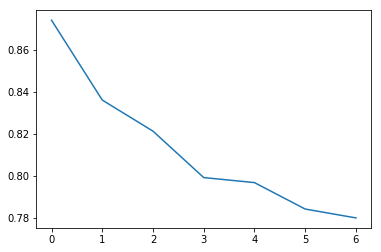

In [27]:
plt.plot(trainer_net.metrics['valid']['losses'])
plt.show()

In [28]:
trainer_net.load_state('../../models/recomendacao_net')
print('Best loss:', trainer_net.metrics['valid']['losses'][-1])

Best loss: 0.7800395729594214


Com esta rede, a perda já é bem melhor, comparável com os melhores sistemas de recomendação.

## Matriz de recomendações, por usuário e por filme

O sistema de recomendação pode ser visualizado por uma matriz onde as linhas sejam os
IDs dos usuários e as colunas sejam os IDs dos títulos dos filmes. Colocamos como -1
os elementos em que não existem avaliações. Esta matriz é bastante esparsa, pois existem
normalmente poucas avaliações feitas.

In [29]:
grid_ratings = -1. * np.ones((n_users,n_movies))
uId = (ratings[:,0]).astype(np.int)
mId = (ratings[:,1]).astype(np.int)
grid_ratings[uId,mId] = ratings[:,2] # Criação da matriz
print(grid_ratings.shape)

(671, 9066)


### Visualização da matriz de recomendações, original

In [30]:
def show_grid(a_ratings):
    a_color = np.clip(a_ratings, 0, None)
    a_cover = (a_ratings == - 1).reshape(a_ratings.shape + (1,)).repeat(4, axis=2).astype(np.float)
    a_cover[:, :, :3] = 0.
    plt.figure(figsize=(8, 8))
    plt.title('usuários (linhas) x filmes (colunas)')
    plt.imshow(a_color, cmap='plasma')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.imshow(a_cover, cmap='gray')
    plt.xlabel('filmes')
    plt.ylabel('usuários')
    plt.tight_layout()
    plt.show()

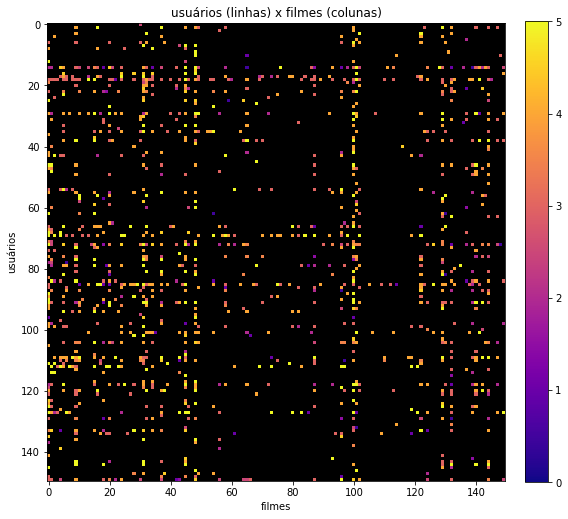

In [31]:
show_grid(grid_ratings[:150, :150])

## Predições para todos os usuários e filmes

In [32]:
n2p_user,n2p_movie = np.nonzero(grid_ratings==-1)
xin = torch.from_numpy(np.array([n2p_user, n2p_movie]).T)
recommend = trainer_net.predict(xin)

### Montagem da matriz de recomendação "cheia"

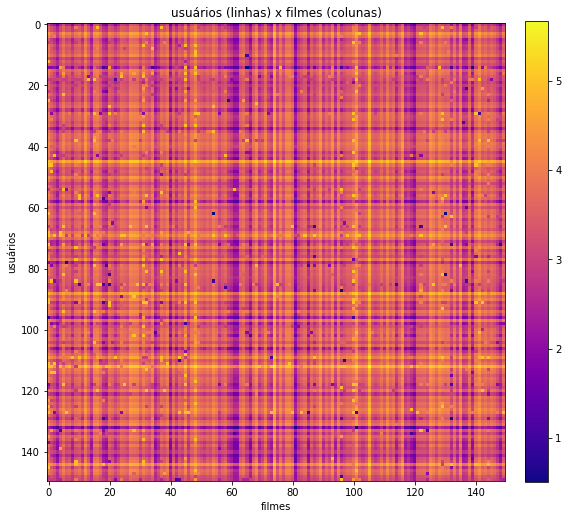

In [33]:
gg = grid_ratings.copy()
gg[n2p_user,n2p_movie] = recommend[:,0].cpu().numpy()
show_grid(gg[:150,:150])

### Visualização da parte de usuários mais ativos e filmes mais populares

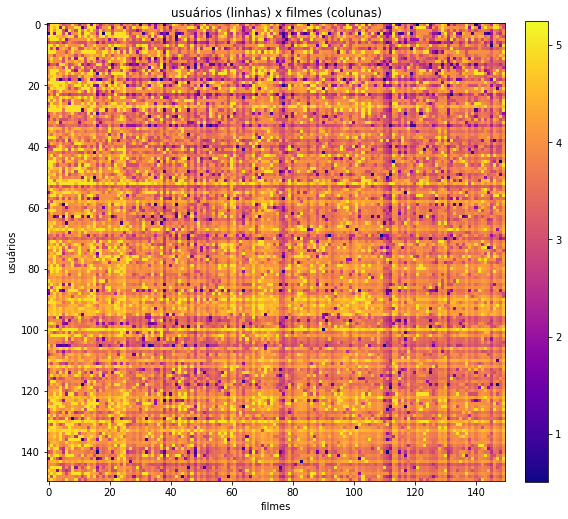

In [34]:
io_popular_movies = np.argsort(h_movieId)[::-1]
io_top_users = np.argsort(h_userId)[::-1].astype(np.int)
gg_ord = gg[np.ix_(io_top_users,io_popular_movies)]
show_grid(gg_ord[:150,:150])

### Visualização dos usuários menos ativos e filmes menos avaliados

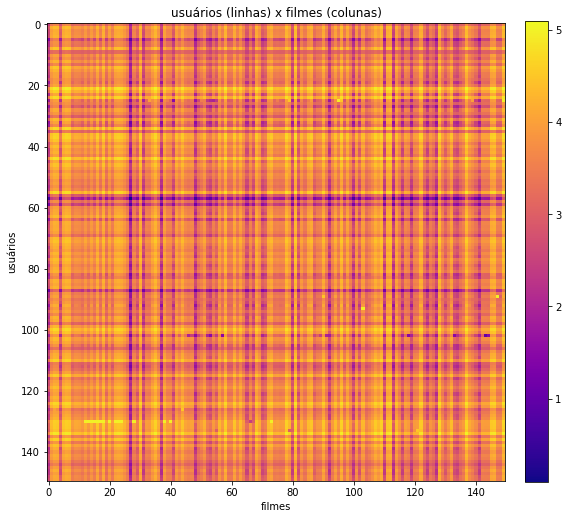

In [35]:
show_grid(gg[-150:,-150:])

## Analise dos embeddings dos filmes

A análise a seguir será feita apenas com os 2000 filmes mais populares:

In [36]:
topMovies = io_popular_movies[:2000].copy()

### Extração dos atributos latentes (embeddings) dos 2000 fimes mais populares

Para obter os atributos latentes dos 2000 filmes mais populares, aplicamos o `topMovies`
na função get_movie_emb que faz parte do objeto model_net, criado na classe RecommendNet:

In [37]:
xin = torch.unsqueeze(torch.LongTensor(topMovies),1)
if use_gpu:
    xin = xin.cuda()
m_emb = model_net.get_movie_emb(Variable(xin))
movie_emb = np.squeeze(m_emb.data.cpu().numpy()) # elimina dimensões 1
movie_emb.shape

(2000, 50)

Como o embedding de cada filme tem dimensão 50, é muito difícil conseguir analisá-lo desta forma.
Uma forma muito usual é reduzir esta dimensionalidade utilizando uma técnica denominada PCA -
Principal Component Analysis: [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/).
Iremos reduzir a dimensão dos embeddings de 50 para 2. 

In [38]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
movie_pca = pca.fit(movie_emb.T).components_

#### Filmes com alto valor na primeira dimensão do PCA

In [39]:
fac0 = movie_pca[0]
isort = np.argsort(fac0)[::-1]

for ii in isort[:15]:
    print(fac0[ii],movie_names[ii])

0.065104425 Governess, The (1998)
0.0594626 Mulan (1998)
0.059349116 Wings of the Dove, The (1997)
0.056690827 Patch Adams (1998)
0.056108624 Back to the Future Part II (1989)
0.05205134 Star Trek II: The Wrath of Khan (1982)
0.05165228 Saboteur (1942)
0.051590748 Godzilla (Gojira) (1954)
0.051515114 Police Academy 4: Citizens on Patrol (1987)
0.051382136 Glen or Glenda (1953)
0.05101033 Antz (1998)
0.050475962 Friday the 13th Part VII: The New Blood (1988)
0.049343217 Man for All Seasons, A (1966)
0.049229227 E.T. the Extra-Terrestrial (1982)
0.04905448 187 (One Eight Seven) (1997)


#### Filmes com baixo valor na primeira dimensão do PCA

In [40]:
for ii in isort[-15:]:
    print(fac0[ii],movie_names[ii])

-0.04977064 This Is Spinal Tap (1984)
-0.05018357 Spirits of the Dead (1968)
-0.050424352 Species (1995)
-0.05047551 Kicking and Screaming (1995)
-0.050988954 Glory (1989)
-0.051094543 Bio-Dome (1996)
-0.051849995 Elephant Man, The (1980)
-0.051913876 Phantom, The (1996)
-0.052410487 Cape Fear (1962)
-0.05355458 La Cérémonie (1995)
-0.05419518 Naked (1993)
-0.054322824 Grumpier Old Men (1995)
-0.054530192 Fly II, The (1989)
-0.05607132 King Kong (1933)
-0.05710198 Othello (1995)


### Análise da segunda dimensão do PCA

In [41]:
fac1 = movie_pca[1]
isort = np.argsort(fac1)[::-1]

#### Mais bem avaliados na segunda dimensão

In [42]:
for ii in isort[:15]:
    print(fac1[ii],movie_names[ii])

0.08113314 One Magic Christmas (1985)
0.071523815 Rocky IV (1985)
0.0683669 Party Girl (1995)
0.06554273 Dead Tired (Grosse Fatigue) (1994)
0.065331236 Jane Austen's Mafia! (1998)
0.058412425 Léon: The Professional (a.k.a. The Professional) (Léon) (1994)
0.057755347 Saboteur (1942)
0.05734207 Outside Ozona (1998)
0.056472573 Stars and Bars (1988)
0.056146283 Still Crazy (1998)
0.05555133 Polish Wedding (1998)
0.055430494 Apple Dumpling Gang Rides Again, The (1979)
0.055104665 Damsel in Distress, A (1937)
0.054456964 Star Maps (1997)
0.053530224 Herbie Goes Bananas (1980)


#### Piores avaliados na segunda dimensão

In [43]:
for ii in isort[-15:]:
    print(fac1[ii],movie_names[ii])

-0.05960395 Nightmare Before Christmas, The (1993)
-0.061677188 Choices (1981)
-0.062089916 Ciao, Professore! (Io speriamo che me la cavo) (1992)
-0.06388907 Gay Divorcee, The (1934)
-0.06510347 Unforgiven (1992)
-0.06674361 Miller's Crossing (1990)
-0.06704824 Deceiver (1997)
-0.0683054 Inkwell, The (1994)
-0.07009334 Private Benjamin (1980)
-0.07012093 Four Days in September (O Que É Isso, Companheiro?) (1997)
-0.07042614 Hurlyburly (1998)
-0.07164025 Denise Calls Up (1995)
-0.073059924 Still Breathing (1997)
-0.082925506 Amadeus (1984)
-0.08384651 Red Rock West (1992)


### Visualizando duas dimensões do PCA

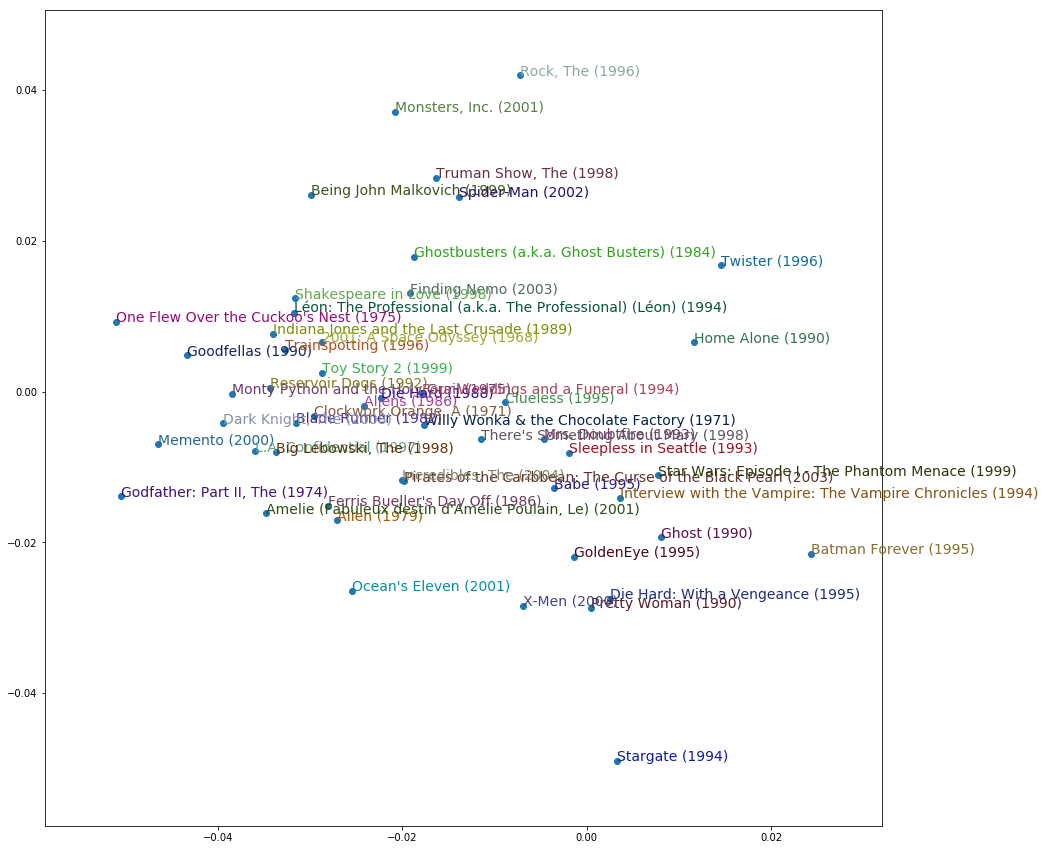

In [44]:
start=50; end=100
X = fac0[start:end]
Y = fac1[start:end]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[start:end], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=14)
plt.show()

## Exercícios

1. Inclua um novo usuário, sem nenhuma avaliação. Treine a rede e verifique
   se após a rede treinada, se haverá alguma avaliação.
2. Com o novo usuário, faça uma única avaliação e verifique quais os 10 filmes
   mais recomendados para ele.

## Aprendizados com este notebook